In [2]:
from time import time
import pandas as pd
import numpy as np
from PIL import Image
import keras.layers.advanced_activations
import scipy
import random
import matplotlib.pyplot as plt  
from scipy.stats import norm  
import keras
from keras.models import Sequential
from keras.initializers import VarianceScaling,RandomNormal
from keras.layers import Input, Dense, Dropout, Conv2D, MaxPooling2D,concatenate
from keras.layers import UpSampling2D, Reshape, Lambda, Flatten, Activation
from keras.models import Model  
from keras.optimizers import SGD, Adadelta, Adagrad,Adam
from keras import backend as K  
from keras import objectives  
from keras.utils.vis_utils import plot_model  
from keras.utils import np_utils, generic_utils
import sys 
import tensorflow as tf
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.layers import BatchNormalization
from keras.layers.normalization import BatchNormalization
import matplotlib.pyplot as plt
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'
import sklearn
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter
%matplotlib inline
from sklearn import manifold, datasets,cluster
from sklearn.utils import check_random_state
from sklearn import metrics

In [3]:
path = os.listdir('SDSS_20k/')

Obj_ID = []
Image = []
Class = []
Redshift = []
for i in range(len(path)):
    path_now = path[i]
    a = np.load('SDSS_20k/'+str(path_now))
    for j in range(a.shape[0]):
        Obj_ID.append(a[j]['objID'])
        Image.append(a[j]['image'])
        Class.append(a[j]['class'])
        Redshift.append(a[j]['z'])

Obj_ID = np.asarray(Obj_ID)
Image = np.asarray(Image)
Class = np.asarray(Class)
Redshift = np.asarray(Redshift)
Class[Class=='STAR'] = 0
Class[Class=='GALAXY'] = 1
Class[Class=='QSO'] = 2
Class = Class.astype(int)

In [5]:
Image_RGB = np.empty((len(Image),64,64,3))#(14142,64,64,3) RGB images
for i in range(len(Image)):
    #b[i] = np.stack((a[i][1][0],a[i][1][1],a[i][1][2],a[i][1][3],a[i][1][4]),axis=-1)
    Image_RGB[i] = np.stack((Image[i][3],Image[i][2],Image[i][1]),axis=-1)


for i in range(len(Image_RGB)):
    if True in np.isnan(Image_RGB[i]).reshape(64*64*3):
        print(i)
        Image_RGB[i][np.isnan(Image_RGB[i])==True]=np.mean(Image_RGB[0])
show_Image_RGB = (Image_RGB - np.min(Image_RGB))/(np.max(Image_RGB) - np.min(Image_RGB))*2 - np.ones_like(Image_RGB)
#Image_RGB -= np.mean(Image_RGB)
#Image_RGB /= np.std((Image_RGB))


Image_RGB /= np.max(Image_RGB)
Image_RGB -= np.mean(Image_RGB)
#Image_RGB = -Image_RGB

872
15249
32951
37879
45552
63104
63918
72767
81185
88285
96972
101023
122609


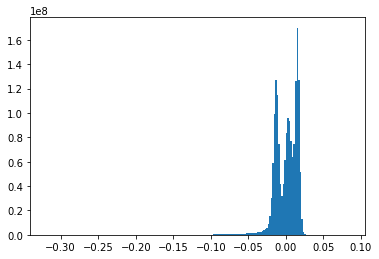

In [6]:
plt.hist(Image_RGB.reshape(-1,),200)
plt.show()

In [7]:
label = np_utils.to_categorical(Class, 3)
data = Image_RGB
index = [i for i in range(len(data))]
#random.shuffle(index)
train_data = data[index]
train_label = label[index]
Class = Class[index]
Redshift = Redshift[index]
show_Image_RGB = show_Image_RGB[index]
print('train_data.shape:',train_data.shape)
print('train_label.shape:',train_label.shape)

train_data.shape: (140976, 64, 64, 3)
train_label.shape: (140976, 3)


In [8]:
batch_size =100
latent_dim = 2
nb_epoch = 50  
epsilon_std = 0.1 
intermediate_dim =256
original_dim = 64*64

#USE = 'autoencoder'
USE = 'vae'
#encoder:

input_img = Input(shape=(64,64,3))


x = Conv2D(40, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(input_img)
x = MaxPooling2D((2, 2),  padding='same')(x)

x = Conv2D(40, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(x)
x = MaxPooling2D((2, 2),  padding='same')(x)

x = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(x)
x = MaxPooling2D((2, 2),  padding='same')(x)

x = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(x)
x = MaxPooling2D((2, 2),  padding='same')(x)

x = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(x)
x = MaxPooling2D((2, 2),  padding='same')(x)

#x = Conv2D(5, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(x)
#x = MaxPooling2D((2, 2),  padding='same')(x)

visual = Flatten()(x)
h_1 = Dense(intermediate_dim, activation='tanh')(visual)
encoded = Dense(latent_dim, activation='relu')(h_1)

z_mean = Dense(latent_dim)(h_1)
z_log_var = Dense(latent_dim)(h_1)

def sampling(args):   
    z_mean, z_log_var = args  
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0.,stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2)* epsilon

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

if USE == 'vae':
    h_3 = Dense(intermediate_dim,activation='tanh')(z)#for VAE

if USE == 'autoencoder':
    h_3 = Dense(intermediate_dim,activation='tanh')(encoded)#for AE
    
    
h_4 = Dense(20*2*2,activation='relu')(h_3)
h_5 = Reshape((2,2,20))(h_4)


x = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(h_5)
x = UpSampling2D((2, 2))(x)

x = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(x)
x = UpSampling2D((2, 2))(x)

x = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(x)
x = UpSampling2D((2, 2))(x)

x = Conv2D(40, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(x)
x = UpSampling2D((2, 2))(x)

x = Conv2D(80,  (3, 3), activation='tanh',padding='same',kernel_initializer='normal')(x)
x = UpSampling2D((2, 2))(x)

decoded = Conv2D(3, (3, 3), activation='tanh', padding='same')(x)

EarlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')


def vae_loss(x, decoded):
    xent_loss = K.sum(K.sum(objectives.binary_crossentropy(x ,decoded),axis=-1),axis=-1)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1) 
    return xent_loss + 1*kl_loss  

def ae_loss(x, decoded):  
    xent_loss = original_dim * objectives.mean_squared_error(x,decoded)
    return xent_loss

if USE == 'autoencoder':
    autoencoder = Model(inputs=input_img, outputs=decoded)
    autoencoder.compile(optimizer='rmsprop', loss=ae_loss)
if USE == 'vae':
    vae = Model(inputs=input_img, outputs=decoded) 
    vae.compile(optimizer='rmsprop', loss=vae_loss) 

In [9]:
vae.fit(train_data[:120000], train_data[:120000],
        shuffle=True,
        epochs=50,
        batch_size=batch_size,
        validation_split = 0.2,callbacks=[EarlyStopping])

Train on 96000 samples, validate on 24000 samples
Epoch 1/50
96000/96000 [==============================] - 84s - loss: -238.3447 - val_loss: -239.6848
Epoch 2/50
96000/96000 [==============================] - 79s - loss: -247.0073 - val_loss: -243.5675
Epoch 3/50
96000/96000 [==============================] - 78s - loss: -246.0021 - val_loss: -244.8810
Epoch 4/50
96000/96000 [==============================] - 78s - loss: -247.6336 - val_loss: -244.8919
Epoch 5/50
96000/96000 [==============================] - 77s - loss: -247.9174 - val_loss: -244.1568
Epoch 6/50
96000/96000 [==============================] - 76s - loss: -248.1091 - val_loss: -244.4918
Epoch 7/50
96000/96000 [==============================] - 76s - loss: -247.6087 - val_loss: -245.3794
Epoch 8/50
96000/96000 [==============================] - 77s - loss: -248.0323 - val_loss: -245.1998
Epoch 9/50
96000/96000 [==============================] - 77s - loss: -248.2664 - val_loss: -244.6528
Epoch 10/50
96000/96000 [=======

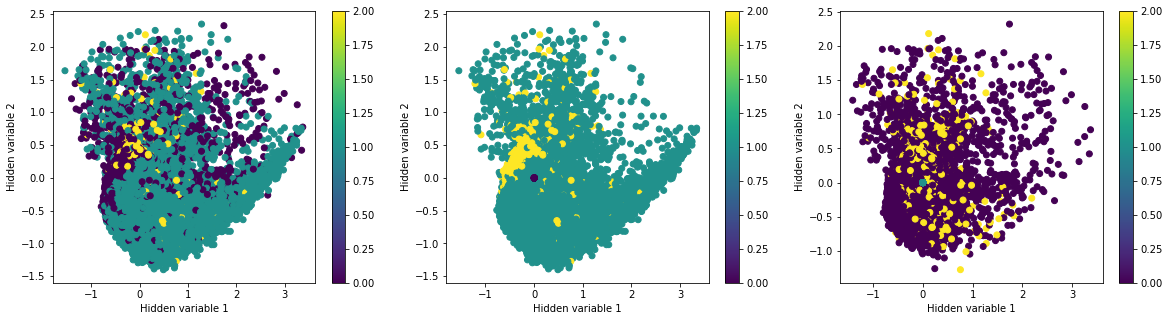

In [10]:
lower_lim = 0
upper_lim = 120000

label_value = np.zeros(len(train_label))
for i in range(len(label_value)):
    label_value[i] =np.argmax(train_label[i])

vis = Model(input_img, z_mean)

# display a 2D plot of the digit classes in the latent space  
x_vis = vis.predict(train_data[lower_lim:upper_lim], batch_size=batch_size)

x_vis_1 = vis.predict(train_data[lower_lim:upper_lim], batch_size=batch_size)  
x_vis_1[label_value[lower_lim:upper_lim]<1]=0

x_vis_2 = vis.predict(train_data[lower_lim:upper_lim], batch_size=batch_size)  
x_vis_2[label_value[lower_lim:upper_lim]==1]=0

plt.figure(figsize=(20, 5))

ax = plt.subplot(1,3,1)
plt.scatter( x_vis[:, 0] ,x_vis[:, 1],c=label_value[lower_lim:upper_lim])
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
ax = plt.subplot(1,3,2)
plt.scatter( x_vis_1[:, 0] ,x_vis_1[:, 1],c=label_value[lower_lim:upper_lim])
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
ax = plt.subplot(1,3,3)
plt.scatter( x_vis_2[:, 0] ,x_vis_2[:, 1],c=label_value[lower_lim:upper_lim])
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
plt.show()

In [11]:
batch_size =100
latent_dim = 2
nb_epoch = 50  
epsilon_std = 0.1 
intermediate_dim =256
original_dim = 64*64

USE = 'autoencoder'
#USE = 'vae'
#encoder:

input_img = Input(shape=(64,64,3))


x = Conv2D(40, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(input_img)
x = MaxPooling2D((2, 2),  padding='same')(x)

x = Conv2D(40, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(x)
x = MaxPooling2D((2, 2),  padding='same')(x)

x = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(x)
x = MaxPooling2D((2, 2),  padding='same')(x)

x = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(x)
x = MaxPooling2D((2, 2),  padding='same')(x)

x = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(x)
x = MaxPooling2D((2, 2),  padding='same')(x)

#x = Conv2D(5, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(x)
#x = MaxPooling2D((2, 2),  padding='same')(x)

visual = Flatten()(x)
h_1 = Dense(intermediate_dim, activation='tanh')(visual)
encoded = Dense(latent_dim, activation='relu')(h_1)

if USE == 'autoencoder':
    h_3 = Dense(intermediate_dim,activation='tanh')(encoded)#for AE
    
    
h_4 = Dense(20*2*2,activation='relu')(h_3)
h_5 = Reshape((2,2,20))(h_4)


x = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(h_5)
x = UpSampling2D((2, 2))(x)

x = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(x)
x = UpSampling2D((2, 2))(x)

x = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(x)
x = UpSampling2D((2, 2))(x)

x = Conv2D(40, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(x)
x = UpSampling2D((2, 2))(x)

x = Conv2D(80,  (3, 3), activation='tanh',padding='same',kernel_initializer='normal')(x)
x = UpSampling2D((2, 2))(x)

decoded = Conv2D(3, (3, 3), activation='tanh', padding='same')(x)

EarlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')


def vae_loss(x, decoded):
    xent_loss = K.sum(K.sum(objectives.binary_crossentropy(x ,decoded),axis=-1),axis=-1)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1) 
    return xent_loss + 1*kl_loss  

def ae_loss(x, decoded):  
    xent_loss = original_dim * objectives.mean_squared_error(x,decoded)
    return xent_loss

if USE == 'autoencoder':
    autoencoder = Model(inputs=input_img, outputs=decoded)
    autoencoder.compile(optimizer='rmsprop', loss=ae_loss)
if USE == 'vae':
    vae = Model(inputs=input_img, outputs=decoded) 
    vae.compile(optimizer='rmsprop', loss=vae_loss) 

In [12]:
autoencoder.fit(train_data[:120000], train_data[:120000],
        shuffle=True,
        epochs=50,
        batch_size=batch_size,
        validation_split = 0.2,callbacks=[EarlyStopping])

Train on 96000 samples, validate on 24000 samples
Epoch 1/50
96000/96000 [==============================] - 74s - loss: 0.3841 - val_loss: 0.3486
Epoch 2/50
96000/96000 [==============================] - 77s - loss: 0.3618 - val_loss: 0.3417
Epoch 3/50
96000/96000 [==============================] - 77s - loss: 0.3608 - val_loss: 0.3516
Epoch 4/50
96000/96000 [==============================] - 78s - loss: 0.3603 - val_loss: 0.3501
Epoch 5/50
96000/96000 [==============================] - 76s - loss: 0.3607 - val_loss: 0.3412
Epoch 6/50
96000/96000 [==============================] - 76s - loss: 0.3605 - val_loss: 0.3398
Epoch 7/50
96000/96000 [==============================] - 76s - loss: 0.3604 - val_loss: 0.3418
Epoch 8/50
96000/96000 [==============================] - 76s - loss: 0.3606 - val_loss: 0.3446
Epoch 9/50
96000/96000 [==============================] - 76s - loss: 0.3608 - val_loss: 0.3411
Epoch 10/50
96000/96000 [==============================] - 75s - loss: 0.3605 - val_lo

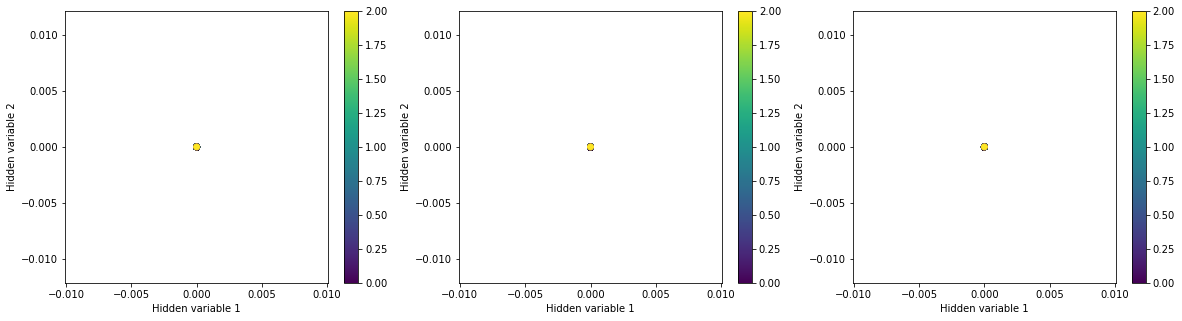

In [13]:
lower_lim = 0
upper_lim = 120000

label_value = np.zeros(len(train_label))
for i in range(len(label_value)):
    label_value[i] =np.argmax(train_label[i])

vis = Model(input_img, encoded)

# display a 2D plot of the digit classes in the latent space  
x_vis = vis.predict(train_data[lower_lim:upper_lim], batch_size=batch_size)

x_vis_1 = vis.predict(train_data[lower_lim:upper_lim], batch_size=batch_size)  
x_vis_1[label_value[lower_lim:upper_lim]<1]=0

x_vis_2 = vis.predict(train_data[lower_lim:upper_lim], batch_size=batch_size)  
x_vis_2[label_value[lower_lim:upper_lim]==1]=0

plt.figure(figsize=(20, 5))

ax = plt.subplot(1,3,1)
plt.scatter( x_vis[:, 0] ,x_vis[:, 1],c=label_value[lower_lim:upper_lim])
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
ax = plt.subplot(1,3,2)
plt.scatter( x_vis_1[:, 0] ,x_vis_1[:, 1],c=label_value[lower_lim:upper_lim])
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
ax = plt.subplot(1,3,3)
plt.scatter( x_vis_2[:, 0] ,x_vis_2[:, 1],c=label_value[lower_lim:upper_lim])
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
plt.show()